In [1]:
import sympy as sp
import numpy as np
from typing import *
import matplotlib.pyplot as plt
sp.init_printing(use_latex=True)

Throughout the assignment we will define $x:=x_1$, $y:=x_2$, and $\bold x:=[x,y]^T$ to make the assignment concistent as subscripts can not be used when defining variables in SymPy

The Rosenbrock function is defined as 
$$
f(\bold x) = 100(y-x^2)^2+(1-x)^2
$$

In [2]:
x, y = sp.symbols("x y")
f = 100*(y - x**2)**2 + (1 - x)**2

# 1

In [9]:
df = sp.Matrix([sp.diff(f, x), sp.diff(f, y)])
df

⎡        ⎛   2    ⎞          ⎤
⎢- 400⋅x⋅⎝- x  + y⎠ + 2⋅x - 2⎥
⎢                            ⎥
⎢             2              ⎥
⎣      - 200⋅x  + 200⋅y      ⎦

To compute the gradient, we compute the partial derivatives for *f* w.r.t. *x* and *y*.
$$
\frac{d}{dx}f(\bold x)=2\cdot 100(y-x^2)\cdot (-2x)+2(1-x)\cdot (-1)=-400x(y-x^2)-2(1-x)
$$
$$
\frac{d}{dx}f(\bold y)= 2\cdot 100(y-x^2)\cdot=200(y-x^2)
$$

We now have all we need to construct the gradient
$$
\nabla f(\bold x)=\begin{bmatrix}\frac{d}{dx}f(\bold x) \\ \frac{d}{dy}f(\bold x)\end{bmatrix} = \begin{bmatrix} -400x(y-x^2)-2(1-x)\\200(y-x^2)\end{bmatrix}
$$

The Hessian contains the second order derivatives
$$
H = \begin{bmatrix}\frac{d}{dx^2}f(\bold x) & \frac{d}{dxdy}f(\bold x)\\
\frac{d}{dydx}f(\bold x) & \frac{d}{dy^2}f(\bold x)\end{bmatrix}

In [11]:
d2f = sp.Matrix([
    [sp.diff(df[0], x), sp.diff(df[0], y)],
    [sp.diff(df[1], x), sp.diff(df[1], y)]
])
d2f

⎡      2                    ⎤
⎢1200⋅x  - 400⋅y + 2  -400⋅x⎥
⎢                           ⎥
⎣      -400⋅x          200  ⎦

$$\frac{d}{dx^2}f(\bold x)=-400(y-x^2)-400x\cdot (-2x)+2=-400(y-x^2)+800x^2+2=1200x^2-400y+2$$
$$\frac{d}{dy^2}f(\bold x)=200$$

Luckily, the Hessian is symmetric so we only need to calculate one of the mixed derivatives.

$$\frac{d}{dxdy}f(\bold x)=-400x$$

We can now state the Hessian
$$
H = \begin{bmatrix}1200x^2-400y+2 & -400x\\
-400x & 200
\end{bmatrix}
$$

# 2

To ensure that $x^*=[1,1]^T$ is the only local minimizer, we will start by determining all the stationary points, as all local minimizers must satisfy the first-order optimality condition.

We thus want to solve the equation
$$
\nabla f(\bold x)= \begin{bmatrix} -400x(y-x^2)-2(1-x)\\200(y-x^2)\end{bmatrix} = 0
$$

Looking at the second equation $200(y-x^2)=0$ we see that this equation only holds when $y=x^2$.

By inserting this requirements into the other equation, we can greatly simplify it
$$-400x(x^2-x^2)-2(1-x)=0\Leftrightarrow$$
$$-2+2x=0\Leftrightarrow$$
$$x=1$$

Since we know that $y=x^2$ we have that $y=1$.

We now know that the function only has one stationary point $(1,1)$

Let's now insert the stationary point into the Hessian to determine if it's a minimizer or maximizer
$$H([1,1]) = \begin{bmatrix} 1200+400+2 & -400 \\ -400 & 200\end{bmatrix}=\begin{bmatrix} 1602 & -400 \\ -400 & 200\end{bmatrix}$$

In [15]:
eigs = np.linalg.eig(np.array([[1602, -400], [-400, 200]]))
print(eigs)

EigResult(eigenvalues=array([1708.09417047,   93.90582953]), eigenvectors=array([[ 0.96657849,  0.25637086],
       [-0.25637086,  0.96657849]]))


Since the eigenvalues are positive, (1,1) is a local minimizer

# 7

## c

In [8]:
def newtons_method(f: sp.Expr, vars: list[sp.Symbol], x0: np.ndarray, alpha: float=1, max_iter: int = 2000, tol: float=10e-10):
    if x0.ndim == 2:
        x0 = x0.squeeze()
    df = sp.Matrix([sp.diff(f, v) for v in vars])
    d2f = sp.Matrix([[sp.diff(expr, v) for v in vars] for expr in df])

    f = sp.lambdify(vars, f)
    df = sp.lambdify(vars, df)
    d2f = sp.lambdify(vars, d2f)

    xs = [x0]
    fs = [f(*x0)]

    x = x0
    
    k = 0
    while (k < max_iter) and (np.linalg.norm(df(*x), np.inf) >= tol):
        x = x.copy()
        p = -np.linalg.pinv(d2f(*x)) @ df(*x)
        p = p.squeeze()
        # print(f"x: {x}")
        # print(f"p: {p}")
        
        x += alpha*p
        # print(f"new x: {x}")

        xs.append(x)
        fs.append(f(*x))

        k += 1
        # print(np.linalg.norm(x, np.inf))
        # if k > 5:
        #     break

    return xs, fs, k

In [9]:
def get_errors(xs, x_star):
    return [np.linalg.norm(v - x_star, 2) for v in xs]

In [10]:
def plot_opt_stats_newton(fs, k, x0, errors):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].semilogy(range(k+1), fs)
    axes[0].set_title(fr"Function value of Newton's method with $x_0=$({x0[0]}, {x0[1]})")
    axes[0].set_ylabel("$f(x)$")
    axes[0].set_xlabel("Iterations")
 
    axes[1].semilogy(range(k+1), errors)
    axes[1].set_title(r"Error of Newton's method with $\alpha$=1")
    axes[1].set_ylabel("$e_k$")
    axes[1].set_xlabel("Iterations")
    axes[1].set_yscale("log")
    plt.show()


In [11]:
def plot_iterations_on_contour(xs, fs, f, padding=2):
    n_points = 200
    min_x = min(xs, key=lambda x: x[0]) - padding
    max_x = max(xs, key=lambda x: x[0]) + padding
    min_y = min(xs, key=lambda x: x[1]) - padding
    max_y = max(xs, key=lambda x: x[1]) + padding
    xs_c = np.linspace(min_x, max_x, n_points)
    ys_c = np.linspace(min_y, max_y, n_points)

    xv, yv = np.meshgrid(xs_c, ys_c)
    fs_c = f(xv, yv)
    # for i in range(n_points):
    #     for j in range(n_points):
    #         fs_c[i, j] = f(xv[i, j], yv[i, j])
    
    plt.contourf(xv, yv, fs_c)

    

    # plt.plot(xs, fs)



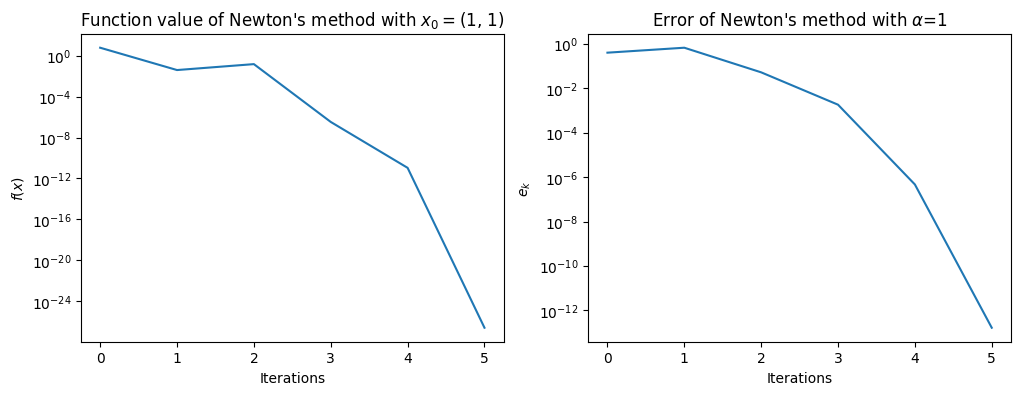

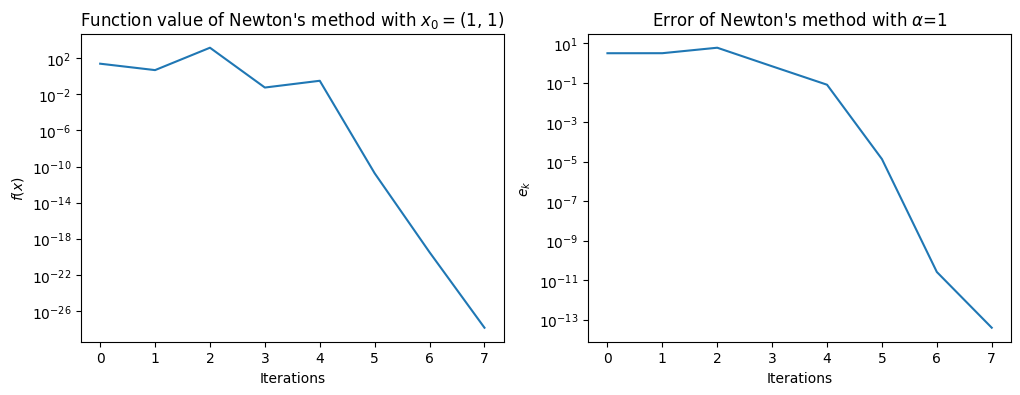

In [12]:
x0s = [np.array([1.2, 1.2]), np.array([-1.2, 1])]
x_star = np.array([[1],[1]])
for x0 in x0s:
    xs, fs, k = newtons_method(f, [x, y], x0)
    errors = get_errors(xs, x_star)
    plot_opt_stats_newton(fs ,k, np.array([1,1]), errors)

In [13]:
fl = sp.lambdify([x, y], f)
plot_iterations_on_contour(xs, fs, fl)

Error in callback <function _draw_all_if_interactive at 0x000001D48D0432E0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001D4907BCD60> (for post_execute):


KeyboardInterrupt: 